# Clustering with K-Means

In [46]:
import pandas as pd
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt
import locale
locale.setlocale(locale.LC_TIME, "id_ID")

'id_ID'

## Load Post Processing Data


In [47]:
# load from data

files_categories = {
    'Kasus Harian' :  'Kasus Harian_post_processing.csv',
    'Kasus Aktif' :  'Kasus Aktif_post_processing.csv',
    'Sembuh Harian' :  'Sembuh Harian_post_processing.csv',
    'Sembuh' :  'Sembuh Harian_post_processing.csv',
    'Meninggal Dunia Harian' :  'Meninggal Dunia Harian_post_processing.csv',
    'Meninggal Dunia' :  'Meninggal Dunia_post_processing.csv',
    'Total Case' :  'Total Case_post_processing.csv'
}

df_categories = {}
df_date_time = {}
for category in files_categories:
    # get the value
    csv_file_name = "../data/{}".format(files_categories[category])

    # load data
    df_categories[category] = pd.read_csv(csv_file_name)
    df_date_time[category] = df_categories[category].pop('Time')
    df_categories[category].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 357 entries, 0 to 356
Data columns (total 34 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   Aceh       357 non-null    int64
 1   Bali       357 non-null    int64
 2   Banten     357 non-null    int64
 3   Babel      357 non-null    int64
 4   Bengkulu   357 non-null    int64
 5   DIY        357 non-null    int64
 6   Jakarta    357 non-null    int64
 7   Jambi      357 non-null    int64
 8   Jabar      357 non-null    int64
 9   Jateng     357 non-null    int64
 10  Jatim      357 non-null    int64
 11  Kalbar     357 non-null    int64
 12  Kaltim     357 non-null    int64
 13  Kalteng    357 non-null    int64
 14  Kalsel     357 non-null    int64
 15  Kaltara    357 non-null    int64
 16  Kep Riau   357 non-null    int64
 17  NTB        357 non-null    int64
 18  Sumsel     357 non-null    int64
 19  Sumbar     357 non-null    int64
 20  Sulut      357 non-null    int64
 21  Sumut      357 n

## Feature Engineering
We want to make daily zone clustering using k-Means thus we decided to choose 2 feature cured daily rated and death daily rated for easier visualization.


$\ \text{daily cured rate} = \frac{\text{daily cured}}{\text{active case}} $

$\ \text{daily death rate} = \frac{\text{daily death}}{\text{active case}} $



In [48]:
# df_features = pd.DataFrame()
df_daily_cured_rate = df_categories['Sembuh Harian'].tail(1) / df_categories['Kasus Aktif'].tail(1)
df_daily_death_rate = df_categories['Meninggal Dunia Harian'].tail(1) / df_categories['Kasus Aktif'].tail(1)

In [49]:
#concat dataframe
frames = [df_daily_cured_rate,df_daily_death_rate]
df_features = pd.concat(frames)
df_features = df_features.reset_index()
del df_features['index']

In [50]:
# rename columns for clearer dataframe
df_features = df_features.rename(index={0 : 'daily_cured_rate' , 1 : 'daily_death_rate'})

#transpose df_features
df_features = df_features.transpose()

# normalization using min max scalar value-min/max-min
df_features = ( df_features - df_features.min() ) / ( df_features.max() - df_features.min() )

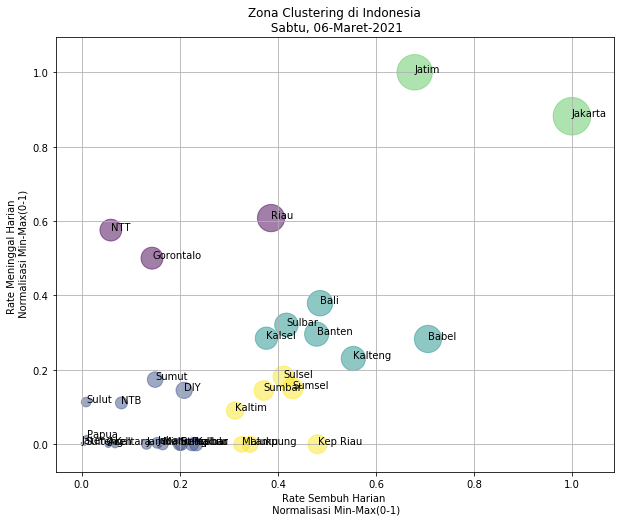

In [51]:
# predict
y_predicts = KMeans(n_clusters=5).fit_predict(df_features)


# set size for plot from mean of 2 columns
size_points = 10 * 150 * df_features.mean(axis=1)

# visualize
fig = plt.figure(figsize=(10, 8))
ax = plt.subplot(111)
plt.scatter(df_features['daily_cured_rate'], df_features['daily_death_rate'], c=y_predicts, s=size_points, alpha=0.5)
ax.grid(True)

for index, rows in df_features.iterrows():
    plt.annotate(index, (rows[0],rows[1]))


# make legends class
# produce a legend with the unique colors from the scatter
#legend1 = ax.legend(*scatter.legend_elements(),
#                    loc="lower left", title="Classes")
#ax.add_artist(legend1)
latest_dt = pd.to_datetime(df_date_time['Kasus Aktif'].tail(1))
readable_datetime = latest_dt.dt.strftime('%A, %d-%B-%Y').values[0]
plt.title("Zona Clustering di Indonesia\n {}".format(readable_datetime))
plt.xlabel("Rate Sembuh Harian \n Normalisasi Min-Max(0-1)")
plt.ylabel("Rate Meninggal Harian \n Normalisasi Min-Max(0-1)")

plt.savefig('../images/{}_Semua_Provinsi.png'.format("K-Means_"), dpi=100, bbox_inches='tight')
plt.show()

Use positive case per capita and cured-death ratio weekly.


In [52]:
# get population information
df_populations = pd.read_excel('../data/Jumlah_Penduduk_Indonesia_2020.xlsx')
df_populations.info()

df_populations['2020'] = df_populations['2020'] * 1000 # multiple to thousand

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35 entries, 0 to 34
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Provinsi  35 non-null     object 
 1   2020      35 non-null     float64
dtypes: float64(1), object(1)
memory usage: 688.0+ bytes


In [53]:
def province_name_to_abr(province_name : str)->str:
    # Bengkulu,DIY,Jakarta,Jambi,Jabar,Jateng,Jatim,Kalbar,Kaltim,Kalteng,Kalsel,Kaltara,Kep Riau,NTB,Sumsel,Sumbar,Sulut,Sumut,Sultra,Sulsel,Sulteng,Lampung,Riau,Malut,Maluku,Papbar,Papua,Sulbar,NTT,Gorontalo
    provinces_map = {
        'SUMATERA UTARA' : 'Sumut',
        'KEP. BANGKA BELITUNG' : 'Babel',
        'SUMATERA BARAT' : 'Sumbar',
        'SUMATERA SELATAN' : 'Sumsel',
        'KEP. BANGKA BELITUNG' : 'Babel',
        'KEP. RIAU' : 'Kep Riau',
        'DKI JAKARTA' : 'Jakarta',
        'JAWA BARAT' : 'Jabar',
        'JAWA TENGAH': 'Jateng',
        'DI YOGYAKARTA' : 'DIY',
        'JAWA TIMUR' : 'Jatim',
        'NUSA TENGGARA BARAT' : 'NTB',
        'NUSA TENGGARA TIMUR' : 'NTT',
        'KALIMANTAN BARAT' : 'Kalbar',
        'KALIMANTAN TENGAH' : 'Kalteng',
        'KALIMANTAN SELATAN' : 'Kalsel',
        'KALIMANTAN TIMUR' : 'Kaltim',
        'KALIMANTAN UTARA' : 'Kaltara',
        'SULAWESI UTARA' : 'Sulut',
        'SULAWESI TENGAH' : 'Sulteng',
        'SULAWESI SELATAN' : 'Sulsel',
        'SULAWESI TENGGARA' : 'Sultra',
        'SULAWESI BARAT' : 'Sulbar',
        'MALUKU UTARA' : 'Malut',
        'PAPUA BARAT' : 'Papbar'
    }

    try:
        return provinces_map[province_name]
    except:
        return province_name.capitalize()


print(province_name_to_abr('MALUKU UTARA'))
print(province_name_to_abr('ACEH'))

Malut
Aceh


In [54]:
# mapping
df_populations['Provinsi'] = df_populations['Provinsi'].apply(lambda name : province_name_to_abr(name))
df_populations = df_populations.set_index('Provinsi')
df_populations = df_populations.rename(columns={'2020' : 'population'})
df_populations.head()

,population
Provinsi,
Aceh,5388100.0
Sumut,14798400.0
Sumbar,5545700.0
Riau,6951200.0
Jambi,3604200.0


In [55]:
# merge join by index and rename
df_features_population = pd.merge(df_features, df_populations, how='inner', left_index=True, right_index=True)
df_features_population

# df_features['weekly_active_rate_per_capita'] = df_features[]

,daily_cured_rate,daily_death_rate,population
Aceh,0.054006,0.000000,5388100.0
Bali,0.486077,0.379283,4414400.0
Banten,0.479059,0.296072,12895300.0
Babel,0.706279,0.283140,1469800.0
Bengkulu,0.202825,0.000000,1994300.0
DIY,0.208725,0.145056,3919200.0
Jakarta,1.000000,0.881811,10576400.0
Jambi,0.131960,0.000000,3604200.0
Jabar,0.153888,0.004051,49565200.0
Jateng,0.000000,0.003363,34738200.0


Try to Make new Feature

weekly_active_per_capita

weekly cured and death ratio

weekly_confirmed rate



In [56]:
# df_populations.transpose()

In [57]:
df_weekly_features = pd.DataFrame()
df_weekly_features['weekly_active_average'] = df_categories['Kasus Aktif'].tail(7).mean()
#df_weekly_features['weekly_death_cured_ratio'] =  df_categories['Meninggal Dunia Harian'].tail(7).mean() / df_categories['Sembuh Harian'].tail(7).mean()
# df_weekly_death_average =
df_weekly_features['weekly_confirmed_average'] = df_categories['Kasus Harian'].tail(7).mean()

In [58]:
# merge
df_new_features = pd.merge(df_populations, df_weekly_features, how="inner", left_index=True, right_index=True)


In [59]:
# add per capita columns
df_new_features['weekly_active_capita'] = df_new_features['weekly_active_average'] / df_new_features['population'] * 100
df_new_features['weekly_confirmed_capita'] = df_new_features['weekly_confirmed_average'] / df_new_features['population'] * 100
df_new_features.head()

,population,weekly_active_average,weekly_confirmed_average,weekly_active_capita,weekly_confirmed_capita
Aceh,5388100.0,1315.000000,10.142857,0.024406,0.000188
Sumut,14798400.0,2524.142857,119.000000,0.017057,0.000804
Sumbar,5545700.0,1041.571429,78.285714,0.018782,0.001412
Riau,6951200.0,999.000000,81.428571,0.014372,0.001171
Jambi,3604200.0,1113.000000,22.142857,0.030881,0.000614


In [60]:
#df_features_norm = ( df_new_features[['weekly_active_average','weekly_confirmed_capita']] - df_new_features[['weekly_active_average','weekly_confirmed_capita']].min() ) / ( df_new_features[['weekly_active_average','weekly_confirmed_capita']].max() - df_new_features[['weekly_active_average','weekly_confirmed_capita']].min() )
df_features_norm = ( df_new_features - df_new_features.min() ) / ( df_new_features.max() - df_new_features.min() )
df_features_norm

,population,weekly_active_average,weekly_confirmed_average,weekly_active_capita,weekly_confirmed_capita
Aceh,0.095784,0.026704,0.001560,0.057193,0.000000
Sumut,0.288394,0.054985,0.071468,0.032327,0.042163
Sumbar,0.099010,0.020309,0.045321,0.038163,0.083752
Riau,0.127778,0.019313,0.047339,0.023241,0.067307
Jambi,0.059271,0.021979,0.009266,0.079103,0.029171
Sumsel,0.161541,0.019567,0.027156,0.014341,0.026911
Bengkulu,0.026320,0.000555,0.003303,0.008036,0.031248
Lampung,0.160191,0.017615,0.031009,0.011341,0.032031
Babel,0.015584,0.009306,0.024220,0.106097,0.198703
Kep Riau,0.032771,0.000000,0.002294,0.000000,0.020566


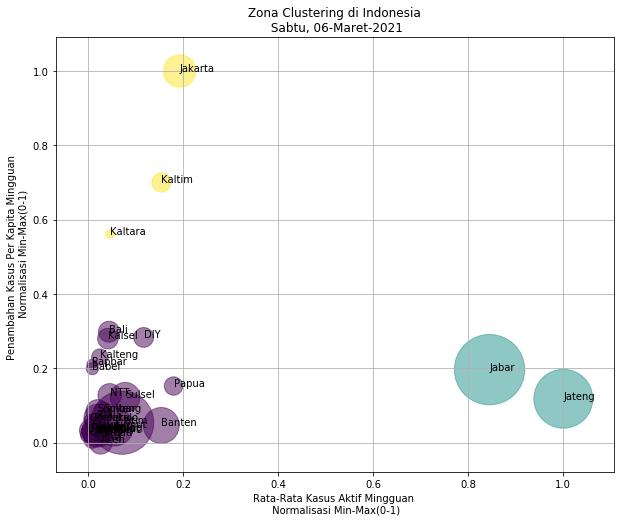

In [61]:
# predict
y_predicts = KMeans(n_clusters=3).fit_predict(df_features_norm[['weekly_active_average','weekly_confirmed_capita']])

size_points =  df_new_features['population'] / 10000

# visualize
fig = plt.figure(figsize=(10, 8))
ax = plt.subplot(111)
plt.scatter(df_features_norm['weekly_active_average'], df_features_norm['weekly_confirmed_capita'], c=y_predicts, s=size_points, alpha=0.5)
ax.grid(True)

for index, rows in df_features_norm.iterrows():
    plt.annotate(index, (rows['weekly_active_average'],rows['weekly_confirmed_capita']))


# make legends class
# produce a legend with the unique colors from the scatter
#legend1 = ax.legend(*scatter.legend_elements(),
#                    loc="lower left", title="Classes")
#ax.add_artist(legend1)
latest_dt = pd.to_datetime(df_date_time['Kasus Aktif'].tail(1))
readable_datetime = latest_dt.dt.strftime('%A, %d-%B-%Y').values[0]
plt.title("Zona Clustering di Indonesia\n {}".format(readable_datetime))
plt.xlabel("Rata-Rata Kasus Aktif Mingguan \n Normalisasi Min-Max(0-1)")
plt.ylabel("Penambahan Kasus Per Kapita Mingguan \n Normalisasi Min-Max(0-1)")

plt.savefig('../images/{}_Semua_Provinsi.png'.format("K-Means_Weekly"), dpi=100, bbox_inches='tight')
plt.show()

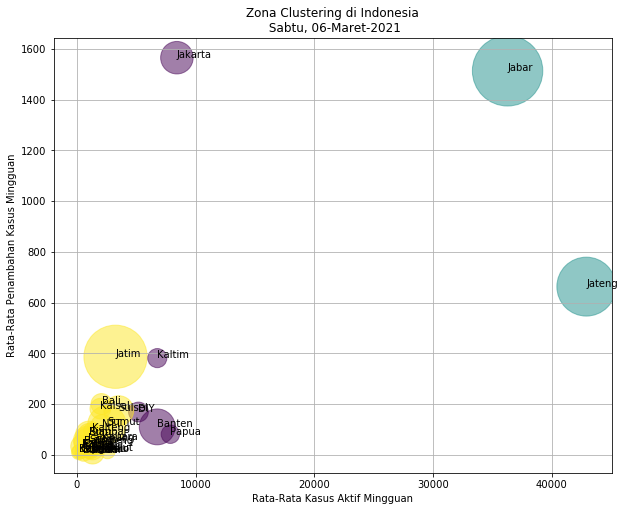

In [62]:
# predict
y_predicts = KMeans(n_clusters=3).fit_predict(df_new_features[['weekly_active_average','weekly_confirmed_average']])


# set size for plot from mean of 2 columns
size_points = df_new_features['population'] / 10000

# visualize
fig = plt.figure(figsize=(10, 8))
ax = plt.subplot(111)
plt.scatter(df_new_features['weekly_active_average'], df_new_features['weekly_confirmed_average'], c=y_predicts, s=size_points, alpha=0.5)
ax.grid(True)

for index, rows in df_new_features.iterrows():
    plt.annotate(index, (rows['weekly_active_average'],rows['weekly_confirmed_average']))


# make legends class
# produce a legend with the unique colors from the scatter
#legend1 = ax.legend(*scatter.legend_elements(),
#                    loc="lower left", title="Classes")
#ax.add_artist(legend1)
latest_dt = pd.to_datetime(df_date_time['Kasus Aktif'].tail(1))
readable_datetime = latest_dt.dt.strftime('%A, %d-%B-%Y').values[0]
plt.title("Zona Clustering di Indonesia\n {}".format(readable_datetime))
plt.xlabel("Rata-Rata Kasus Aktif Mingguan")
plt.ylabel("Rata-Rata Penambahan Kasus Mingguan")

plt.savefig('../images/{}_Semua_Provinsi.png'.format("K-Means_Weekly_no_norm"), dpi=100, bbox_inches='tight')
plt.show()